In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
data=pd.read_csv('data.csv')

In [104]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [105]:
X =data.drop('country',axis=1).values

In [106]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [107]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [108]:
def distance_matrix(X):
    n = len(X)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = euclidean_distance(X[i], X[j])
            D[i, j] = d
            D[j, i] = d
    return D

In [109]:
def hierarchical_average_linkage(X, k):
    n = len(X)

    # Step 1: each point is its own cluster
    clusters = [{i} for i in range(n)]
    sizes = [1] * n

    # Step 2: initial distance matrix
    D = distance_matrix(X)

    while len(clusters) > k:
        # Ignore diagonal by setting it to infinity
        masked_D = D.copy()
        np.fill_diagonal(masked_D, np.inf)

        i, j = np.unravel_index(np.argmin(masked_D), masked_D.shape)

        # Merge clusters i and j
        new_cluster = clusters[i] | clusters[j]
        new_size = sizes[i] + sizes[j]

        # Compute distances from new cluster to others
        new_distances = []
        for m in range(len(clusters)):
            if m != i and m != j:
                d = (sizes[i] * D[i, m] + sizes[j] * D[j, m]) / new_size
                new_distances.append(d)

        # Remove old clusters (remove higher index first!)
        for idx in sorted([i, j], reverse=True):
            clusters.pop(idx)
            sizes.pop(idx)
            D = np.delete(D, idx, axis=0)
            D = np.delete(D, idx, axis=1)

        # Add merged cluster
        clusters.append(new_cluster)
        sizes.append(new_size)

        # Update distance matrix
        new_row = np.array(new_distances + [0.0])
        D = np.vstack([D, new_row[:-1]])
        D = np.column_stack([D, new_row])

    return clusters



In [110]:
def clusters_to_labels(clusters, n):
    labels = np.zeros(n, dtype=int)
    for idx, cluster in enumerate(clusters):
        for point in cluster:
            labels[point] = idx
    return labels


In [111]:
k = 3

clusters_avg = hierarchical_average_linkage(X_scaled, k)
labels_avg = clusters_to_labels(clusters_avg, len(X_scaled))

data['avg_cluster'] = labels_avg

In [112]:
def silhouette_score(X, labels):
    n = len(X)
    unique_clusters = np.unique(labels)
    silhouette_vals = []

    for i in range(n):
        same_cluster = X[labels == labels[i]]
        other_clusters = [X[labels == c] for c in unique_clusters if c != labels[i]]

        if len(same_cluster) > 1:
            a = np.mean([euclidean_distance(X[i], x) for x in same_cluster if not np.array_equal(x, X[i])])
        else:
            a = 0

        b = np.inf
        for cluster in other_clusters:
            mean_dist = np.mean([euclidean_distance(X[i], x) for x in cluster])
            b = min(b, mean_dist)


        s = (b - a) / max(a, b) if max(a, b) != 0 else 0
        silhouette_vals.append(s)

    return np.mean(silhouette_vals)

In [113]:
sil = silhouette_score(X_scaled, labels_avg)
print("Silhouette Score:", sil)


Silhouette Score: 0.568035311008152


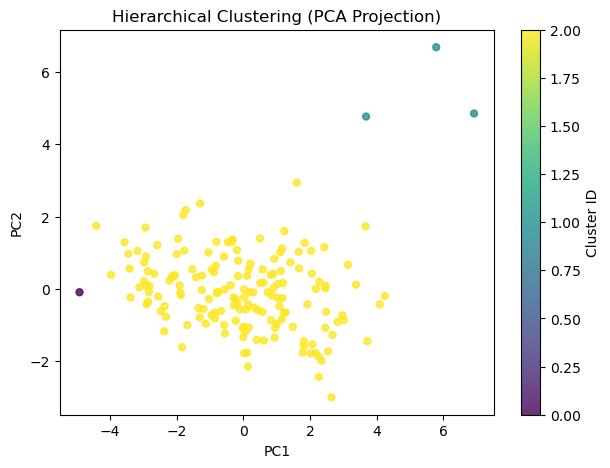

In [114]:
def visualize_pca(X_scaled, clusters):
    
    cov = np.cov(X_scaled, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    W = eigvecs[:, idx[:2]]
    X_pca = X_scaled @ W
    
    
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], 
                c=clusters, cmap='viridis', 
                s=25, alpha=0.8)
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    plt.title("Hierarchical Clustering (PCA Projection)")
    plt.colorbar(label="Cluster ID")
    plt.show()


visualize_pca(X_scaled, labels_avg)

In [115]:
avg_cluster_summary = (
    data
    # Drop the old kmeans column if it exists so it doesn't mess up the averages
    .drop(columns=['kmeans_cluster'], errors='ignore') 
    .groupby('avg_cluster')
    .mean(numeric_only=True)
)

print(avg_cluster_summary)

             child_mort     exports    health     imports        income  \
avg_cluster                                                               
0            130.000000   25.300000  5.070000   17.400000   5150.000000   
1              4.133333  176.000000  6.793333  156.666667  64033.333333   
2             38.335583   38.723307  6.826810   45.050711  16355.294479   

              inflation  life_expec  total_fer          gdpp  
avg_cluster                                                   
0            104.000000   60.500000    5.84000   2330.000000  
1              2.468000   81.433333    1.38000  57566.666667  
2              7.289337   70.417178    2.95908  12208.490798  


In [116]:
for c in sorted(data['avg_cluster'].unique()):
    print(f"\nCluster {c}:")
    
    print(data[data['avg_cluster'] == c]['country'].values)


Cluster 0:
['Nigeria']

Cluster 1:
['Luxembourg' 'Malta' 'Singapore']

Cluster 2:
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada'
 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia'
 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel'
 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Ki